In [19]:
from mnist import MNIST
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
from more_itertools import chunked

In [6]:
mntrain = MNIST('../samples')

In [7]:
img_tr,lbl_tr = mntrain.load_training()
img_ts,lbl_ts = mntrain.load_testing()
img_size = 28 # 28x28 pixels

Label:  4


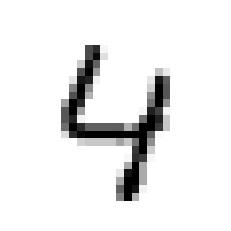

In [8]:
index = random.randrange(0,len(img_tr))
print("Label: ",lbl_tr[index])
image = np.array(img_tr[index]).reshape(img_size,img_size)
plt.imshow(image, cmap=plt.cm.binary)
plt.gcf().axes[0].set_axis_off()

In [9]:
x = [0,1,2,3,4,5,6,7,8,9]
list(reversed(x))

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [10]:
np.matmul(np.zeros((5,2)),np.array([4,5]))

array([0., 0., 0., 0., 0.])

In [11]:
weights = np.random.rand(5, 2)
biases = np.random.rand(5,1)
for i,layer in weights:
    print(i,layer)
print(weights)

0.26148137523724924 0.5692632702448743
0.34471530935630146 0.4916923156362004
0.003958359650476195 0.3812837419654176
0.7662105632930678 0.7314105715358448
0.6463628806765723 0.5137463764701271
[[0.26148138 0.56926327]
 [0.34471531 0.49169232]
 [0.00395836 0.38128374]
 [0.76621056 0.73141057]
 [0.64636288 0.51374638]]


In [40]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def d_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))
def d_sig(x):
    return x*(1-x)

class Layer:
    def __init__(self, depth, length,values=None):
        self.depth = depth
        self.length = length
        self.nodes = np.array([values for _ in range(length)]) if values else np.zeros(length)
    def __str__(self):
        return "Layer: depth: %d, length: %d, nodes: %s" % (self.depth, self.length, self.nodes)
    def __repr__(self):
        return self.__str__()
    def __getitem__(self, index):
        return self.nodes[index]
    def __setitem__(self, index, value):
        self.nodes[index].value = value
    def __iter__(self):
        return iter(self.nodes)
    def __len__(self):
        return len(self.nodes)
    def __contains__(self, item):
        return item in self.nodes
    def __delitem__(self, index):
        del self.nodes[index]
    
    def get_values(self):
        return self.nodes
    def set_values(self, values):
        self.nodes = np.array(values)
    values = property(get_values, set_values)

    
class Neurons:
    def __init__(self, input: Layer, output: Layer):
        self.input = input
        self.output = output
        self.weights = np.random.rand(len(output), len(input))
        self.biases = np.random.rand(len(output))

            
    def __str__(self):
        return "Layer_Connection: layer1: %s, layer2: %s, weights: %s, biases: %s" % (self.input, self.output, self.weights, self.biases)
    def __repr__(self):
        return self.__str__()
    def __getitem__(self, index):
        return self.weights[index]
    def __setitem__(self, index, value):
        self.weights[index] = value
    def __iter__(self):
        return iter(self.weights)
    def __len__(self):
        return self.weights.shape[0] * self.weights.shape[1]
    def __contains__(self, layer):
        return layer in (self.input, self.output)
    def __delitem__(self, index):
        del self.weights[index]


class Neural_Network:
    def __init__(self, input_size, output_size,hidden_size, hidden_layers=1, batch_size=1):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.layers = [Layer(0, input_size)]
        self.layers.extend([Layer(i+1, hidden_size) for i in range(hidden_layers)])
        self.layers.append(Layer(hidden_layers+1, output_size))
        self.neurons = [Neurons(self.layers[i], self.layers[i+1]) for i in range(len(self.layers)-1)]
    
    def __str__(self):
        return "Neural_Network: input_size: %d, hidden_size: %d, output_size: %d, hidden_layers: %d, layers: %s, connections: %s" % (self.input_size, self.hidden_size, self.output_size, len(self.layers)-2, self.layers, self.neurons)
    def __repr__(self):
        return self.__str__()
        
    def output_vector(self):
        return self.layers[-1].values
    
    def output(self):
        return np.argmax(self.output_vector())
    
    def feed_forward(self, image):
        self.layers[0].values = image
        for neuron in self.neurons:
            neuron.output.values = sigmoid(np.matmul(neuron.weights, neuron.input.values) + neuron.biases)


    def back_propagate(self, image, expected, factor):
        self.feed_forward(image)
        # error = np.sum((self.layers[-1].values - expected)**2)
        # error = np.sum(
        # (sigmoid(np.matmul(self.layers[-1].weights, self.layers[-2].values) + self.layers[-1].biases)
        # - expected)**2)
        # nabla_error = 2 * (self.layers[-1].values - expected) * d_sig(self.layers[-1].values)
        # w_nabla = nabla_error * self.layers[-2].values
        # b_nabla = nabla_error
        # self.layers[-1].weights -= factor * w_nabla
        # self.layers[-1].biases -= factor * b_nabla
        for j,i in enumerate(self.neurons[::-1]):
            if j == 0:
                nabla_error = 2 * (i.output.values - expected) * d_sig(i.output.values)
            else:
                nabla_error = np.matmul(i.weights.T, nabla_error) * d_sig(i.output.values)
            
            for k in range(len(i.weights)):
                for l in range(len(i.weights[0])):
                    i.weights[k][l] -= factor * nabla_error[k] * i.input.values[l]
            i.biases -= factor * nabla_error







    # def back_propagate(self, expected, factor):
    #     for i in reversed(self.neurons):
    #         diff = i.output.values - expected
    #         der = d_sig(i.output.values)
    #         coeff = factor * 2 * diff * der

    #         expected = np.matmul(i.weights.T, diff)
    #         for k,k1 in enumerate(i.weights):
    #             for j,j1 in enumerate(k1):
    #                 i.weights[k][j] = i.weights[k][j] - coeff[k] * i.input.values[k]
                

    #         i.biases = coeff
            
            

            
            # j = self.neurons[i]
            # if i == len(self.neurons)-1:
            #     error = expected - j.layer2.values
            # else:
            #     error = np.matmul(self.neurons[i+1].weights.T, error)
            # delta = error * j.layer2.values * (1-j.layer2.values)
            # j.weights += factor * np.matmul(delta.reshape(len(delta),1), j.layer1.values.reshape(1,len(j.layer1.values)))
            # j.biases += factor * delta
            #print(j.weights)
            #print(j.biases)
            #print(error)
            #print(delta)
    
    def test(self, images, labels):
        correct = 0
        for i in tqdm(range(len(images))):
            self.feed_forward(images[i])
            if self.output() == labels[i]:
                correct += 1
        return correct/len(images)

              
    def train(self, images, labels, epochs=1, factor=0.1):
        for _ in range(epochs):
            for j in tqdm(range(len(images))):
                expected = np.zeros(self.output_size)
                expected[labels[j]] = 1
                self.back_propagate(expected,factor)

In [41]:
nn = Neural_Network(784, 10, 16, 1)

In [42]:
w1,b1, w0,b0 = nn.neurons[0].weights, nn.neurons[0].biases , nn.neurons[1].weights, nn.neurons[1].biases

In [43]:
img, lbl = img_tr[0], lbl_tr[0]
print(lbl, img)

5 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 18, 18, 18, 126, 136, 175, 26, 166, 255, 247, 127, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 36, 94, 154, 170, 253, 253, 253, 253, 253, 225, 172, 253, 242, 195, 64, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 49, 238, 253, 253, 253, 253, 253, 253, 253, 253, 251, 93, 82, 82, 56, 39, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 219, 253, 253, 253, 253, 253, 198, 182, 247, 241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80, 156, 107, 253, 253, 205, 11, 0, 43, 154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 1, 154, 253, 90, 0

In [44]:
exp = np.zeros(10)
exp[lbl] = 1
nn.back_propagate(img, exp, 0.1)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 16)

In [17]:
nn.train(img_tr,lbl_tr, 1, 0.1)

100%|██████████| 60000/60000 [08:18<00:00, 120.35it/s]


In [18]:
nn.test(img_ts,lbl_ts)

100%|██████████| 10000/10000 [00:00<00:00, 14595.25it/s]


0.098

In [ ]:
nn.layers[1].values

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
nn.back_propagate(lbl_tr[0])

In [ ]:

nn.feed_forward(img_tr[0])
nn.output_vector()

array([0.9998988 , 0.99990402, 0.99971381, 0.99978931, 0.99950158,
       0.99988421, 0.99964177, 0.99985457, 0.99996816, 0.999723  ])